# Rover Homework

### Import

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Circle
from scipy.io import loadmat
from scipy.integrate import solve_ivp
from scipy.interpolate import UnivariateSpline
import pickle
import os
import sympy as sp
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.interpolate import make_interp_spline
# from Library.load_maps import load_maps
from Library.get_indices import get_indices
from Library.get_indices import get_point
from Library.obstacles_check import obstacles_check
from Library.kinematicModel import kinematicModel
from Library.move2pose import move2pose
from Library.pose2polar import pose2polar
from Library.polar2pose import polar2pose
from Library.A_star_without_reopening import A_star_without_reopening
from Library.EKF import EKF
from Library.dead_reckoning import dead_reckoning
from Library.dead_reckoning import compute_and_plot_ellipses

# from rich.traceback import install
# install(show_locals = True)

### First plots

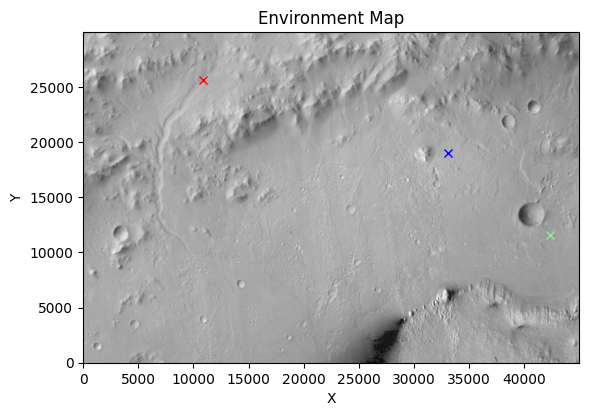

In [2]:
# Set Options
np.set_printoptions(floatmode='fixed', precision=3, suppress=True)

# X, Y, env_map, obstacleMap, xLM, yLM, Xvec, Yvec = load_maps()
# Load the .mat file
filename = 'exercise.mat'
data = loadmat(filename)
# Extract the variables from the loaded data
X = data['X']
Y = data['Y']
env_map = data['map']
obstacleMap = data['obstacleMap']
xLM = data['xLM']
yLM = data['yLM']
Xvec = data['Xvec']
Yvec = data['Yvec']

# Map Resolution
mapRes = 10     # meters per pixel

# Squeeze Xvec and Yvec -> remove unnecessary dimension and comvert them in 1D arrays
Xvec = np.squeeze(Xvec)
Yvec = np.squeeze(Yvec)

# Define Physical Values
L = 3           # m - axles distance
v_max = 4e-2    # m/s - max speed

# Poses
P_0 = np.array([42380, 11590, np.pi/2])  # m, m, rad
P_1 = np.array([33070, 19010, np.pi])    # m, m, rad
P_2 = np.array([10870, 25670])    # m, m

# Show Environment Map
plt.figure("Environment Map")
plt.title("Environment Map")
# library.plot_map(map_image, Xvec, Yvec)
plt.imshow(env_map, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.axis('on')
plt.xlabel('X')
plt.ylabel('Y')

# Plot on the environment map the starting position and the goal positions of the robot
plt.plot(P_0[0], P_0[1], color='lightgreen', marker='x', markersize=6)
plt.plot(P_1[0], P_1[1], color='blue', marker='x', markersize=6)
plt.plot(P_2[0], P_2[1], color='red', marker='x', markersize=6)

plt.show()

# #NOT SURE THEY ARE NEEDED NOW
# # Show obstacle map
# plt.figure()
# plt.imshow(obstacleMap, cmap='gray',  extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()

# # Show landmarks map
# plt.figure()
# plt.imshow(env_map, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
# plt.plot(xLM, yLM, 'yo', markersize=5, linewidth=2)
# plt.grid(True)
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()

## Task 1: Navigation - Moving to a Pose MODIFY THIS

The first task requires the Rover to reach a first new pose using the Moving to a Pose control law.

The gains were selected as follows: K = [1e-4, 1.4e-3, -1.8e-3]

In [3]:
# Compute Relative States
Polar0 = pose2polar(P_0, P_1)
Polar1 = pose2polar(P_1, P_1)

# Convert backwards the Relative State into Pose State
# P_0p = polar2pose(R0, P_1)

P_0_str = [f"{x:.2f}".ljust(10) for x in P_0]
Polar0_str = [f"{x:.2f}".ljust(10) for x in Polar0]
Polar1_str = [f"{x:.2f}".ljust(10) for x in Polar1]

print('\nThe Initial Pose State is:\n',' '.join(P_0_str))
print('\nThe Polar State is:\n',' '.join(Polar0_str))
# print("\nThe Backconverted Initial Pose State is P_0':\n", P_0p)

# Stop function for the integration
# the integration will stop when the robot will reach a distance from the goal position of rho_tol meters
rho_tol = 0.001    # m
def event(t, current_state):
    return current_state[0] - rho_tol
event.terminal = True

# Time Domain
# Initial start time in seconds
t0 = 0 
# Maximum manoeuvre time -> 30 days in seconds
tf = 30 * 24 * 60**2
# Sampling frequency of the trajectory in Hz
freq = 0.1
# tspan generation at given sampling frequency
tspan = np.arange(t0, tf+1, 1/freq)


# Gains [Krho Kalpha Kbeta]
K = np.array([1, 1.48, -1.9])
# res = 1.48e-3 - 1e-3
# print(res)

# Define global variables to store v and omega
v_values = []
omega_values = []
alpha_values = []

# Define a wrapper function for solve_ivp
def wrapper(t, current_state, K, v_values, omega_values, alpha_values):
    dS, v_values, omega_values, alpha_values = kinematicModel(t, current_state, K, v_values, omega_values, alpha_values)
    return dS

# Solve the differential equation
sol = solve_ivp(lambda t, current_state: wrapper(t, current_state, K,  v_values, omega_values, alpha_values), [t0, tf], Polar0, method='RK45', t_eval=tspan, events=event)
tspan = sol.t
current_state = sol.y
P_final = polar2pose(current_state, P_1)
# Print v and omega
print("v values:", v_values[-1])
print("omega values:", omega_values[-1])
# print("alpha values:", alpha_values)

# Check for Obstacles
P_indices = np.array([get_indices(P_final[0:2, i], X, Y, mapRes) for i in range(P_final.shape[1])])    # convert each point in the trajectory to map indices
if obstacles_check(P_indices, obstacleMap):
    print('\n\nThe Trajectory intersects with an Obstacle!\n\n')

P_1r = P_final[:, -1]      # store the real final state of the robot for the next task



The Initial Pose State is:
 42380.00   11590.00   1.57      

The Polar State is:
 11905.15   0.90       0.67      
v values: 0.0005931287937860949
omega values: 3.406512339334139e-08


### Display of the results

In [4]:
# Convert the numbers to strings with a certain width and 2 decimal places just for display purposes
P_0_str = [f"{x:.3f}".ljust(10) for x in P_0]
P_final_str = [f"{x:.3f}".ljust(10) for x in P_final[:, -1]]
P_1_str = [f"{x:.3f}".ljust(10) for x in P_1]
error_str = [f"{x:.3f}".ljust(10) for x in P_final[:, -1] - P_1]

# Log Results
print('Initial state:\t', ' '.join(P_0_str), 'm, m, rad')
print('Final state is:\t', ' '.join(P_final_str), 'm, m, rad')
print('Desired state:\t', ' '.join(P_1_str), 'm, m, rad')
print('\nError:\t', ' '.join(error_str), 'm, m, rad')
print('Final Time: {:.3f} seconds\n'.format(tspan[-1]),'equal to: {:.3f} days'.format(tspan[-1]/ (24 * 60**2)))

Initial state:	 42380.000  11590.000  1.571      m, m, rad
Final state is:	 33070.021  19010.000  3.142      m, m, rad
Desired state:	 33070.000  19010.000  3.142      m, m, rad

Error:	 0.021      0.000      0.000      m, m, rad
Final Time: 331330.000 seconds
 equal to: 3.835 days


### Plot of the trajectory in the environment map

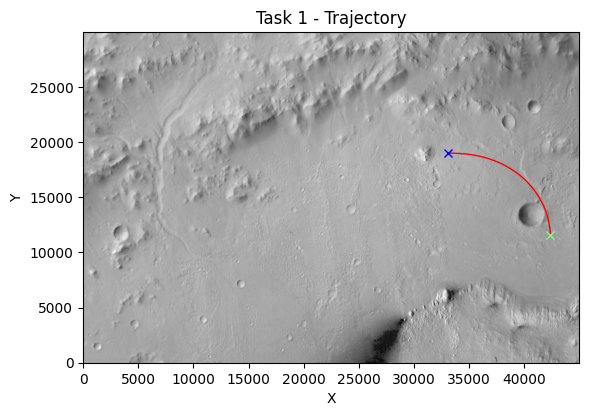

In [5]:
# Environment map with trajectory
plt.figure("Task 1 - Trajectory")
plt.title("Task 1 - Trajectory")
plt.imshow(env_map, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.axis('on')
plt.xlabel('X')
plt.ylabel('Y')
plt.plot(P_final[0, :], P_final[1, :], 'r', linestyle='-', linewidth=1)
plt.plot(P_0[0], P_0[1], color='lightgreen', marker='x', markersize=6)
plt.plot(P_1[0], P_1[1], color='blue', marker='x', markersize=6)


# # animation of the trajectory
# fig, ax = plt.subplots()

# # Set up the plot elements
# plt.title("Task 1 - Trajectory")
# plt.imshow(env_map, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
# plt.axis('on')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.plot(P_0[0], P_0[1], 'gx', markersize=6)
# plt.plot(P_1[0], P_1[1], 'bx', markersize=6)

# # Create a line object for the trajectory
# line, = ax.plot([], [], 'r', linestyle='-', linewidth=1)

# # Initialization function for the animation
# def init():
#     line.set_data([], [])
#     return line,

# # Animation function. This is called sequentially
# def animate(i):
#     x = P[0, :i]
#     y = P[1, :i]
#     line.set_data(x, y)
#     return line,

# matplotlib.rcParams['animation.embed_limit'] = 2**128  # or any large number
# # Create the animation
# ani = animation.FuncAnimation(fig, animate, init_func=init, frames=range(0, len(P[0]), 2), interval=10, blit=True)
# ani.save('Task1.mp4', writer='ffmpeg')


# plt.show()

### Plot of the trajectory in the obstacle map
to show that it doesn't collide with obstacles

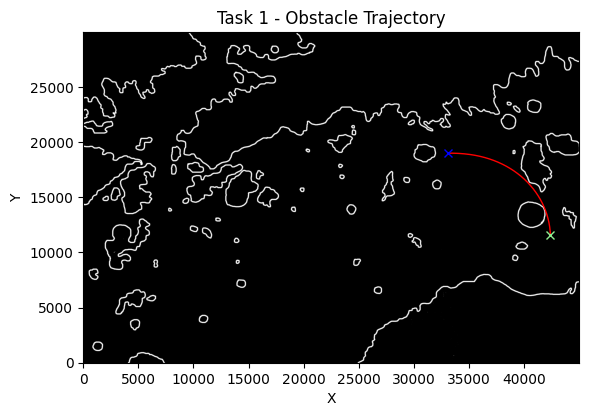

In [6]:
# Obstacle map with trajectory
plt.figure("Task 1 - Obstacle Trajectory")
plt.title("Task 1 - Obstacle Trajectory")
plt.imshow(obstacleMap, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.plot(P_final[0, :], P_final[1, :], 'r', linestyle='-', linewidth=1)
plt.plot(P_0[0], P_0[1], color='lightgreen', marker='x', markersize=6)
plt.plot(P_1[0], P_1[1], color='blue', marker='x', markersize=6)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Task 2: Path Planning - A* Algorithm
initialization and plot of the start and goal position of the task

Start:	 33070.021  19010.000 
Start:	 10870.000  25670.000 
Start indices:	 [1097 3307]
Goal indices:	 [ 432 1087]


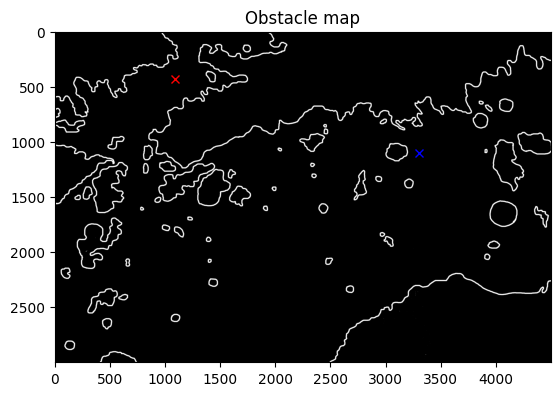

In [8]:
# Start and Goal Coordinates
# the start is the stored value of the real final state of the robot from the previous task
A_star_start = P_1r[0:2]
# the goal is the previously defined P_2
A_star_goal = np.array([P_2[0], P_2[1]])

A_star_start_str = [f"{x:.3f}".ljust(10) for x in A_star_start]
A_star_goal_str = [f"{x:.3f}".ljust(10) for x in A_star_goal]
print('Start:\t', ' '.join(A_star_start_str))
print('Start:\t', ' '.join(A_star_goal_str))

#convert the positions in map indices (pixels) since A* will need pixels to find a path
A_star_start_ind = get_indices(A_star_start, X, Y, mapRes)
A_star_goal_ind = get_indices(A_star_goal, X, Y, mapRes)

#display the values of the start and goal coordinates
print('Start indices:\t', A_star_start_ind)
print('Goal indices:\t', A_star_goal_ind)

# Obstacle map with start and goal coordinates
plt.figure("Obstacle map")
plt.title("Obstacle map")
plt.imshow(obstacleMap, cmap='gray')
plt.plot([A_star_start_ind[1]], [A_star_start_ind[0]], color='blue', marker='x', markersize=6)
plt.plot([A_star_goal_ind[1]], [A_star_goal_ind[0]], color='red', marker='x', markersize=6)
plt.show()

## IF A* WAS NEVER RUN BEFORE

### Compute the path with A*

In [8]:
# find the path using A* algorithm
path = A_star_without_reopening(A_star_start_ind, A_star_goal_ind, obstacleMap)          
# convert to matrix
path = np.array(path)

Finding path: 1553016step [22:32, 1148.04step/s]     


### Plot the A* path

The size of the retrieved path is: 6148


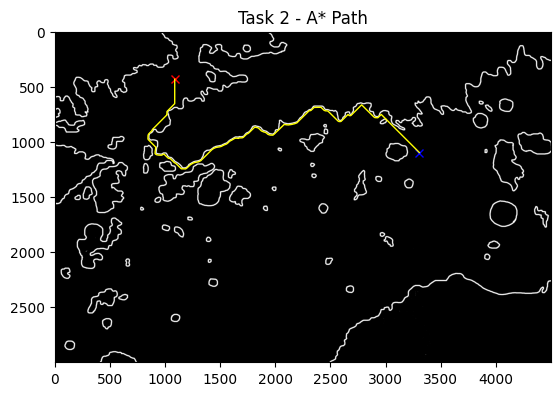

In [9]:
np.save('path.npy', path)
print('The size of the retrieved path is:', path.size)
# Plot the Path
plt.figure("Task 2 - Pathfinding")
plt.title("Task 2 - A* Path")
plt.imshow(obstacleMap, cmap='gray')
plt.plot([A_star_start_ind[1]], [A_star_start_ind[0]], 'bx', markersize=6)
plt.plot([A_star_goal_ind[1]], [A_star_goal_ind[0]], 'rx', markersize=6)
plt.plot(path[:, 1], path[:, 0], c='yellow', linestyle='-', linewidth=1)

plt.show()

## IF A* PATH IS ALREADY IN THE DATA FOLDER

### Load the path and plot it

In [12]:
# data = np.load('Data/path1minusSqrt.npy')  #remenmber to change the name of the file
# path1 = np.array(data)

# data = np.load('Data/pathSqrt.npy')  #remenmber to change the name of the file
# path2 = np.array(data)

# are_equal = np.array_equal(path1, path2)

# print(are_equal)

# are_close = np.allclose(path1, path2)
# print(are_close)

False
False


## DEPENDS ON THE HEURISTIC CHOSEN
Just $\sqrt2$ used

The size of the retrieved path is: 6148


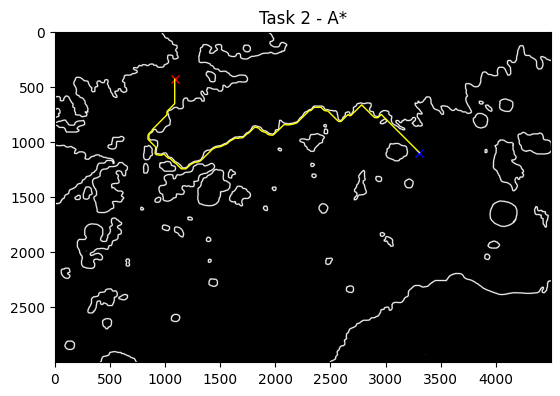

In [9]:
data = np.load('Data/pathSqrt.npy')  #remenmber to change the name of the file
path = np.array(data)
print('The size of the retrieved path is:', path.size)
plt.figure("Task 2")
plt.title("Task 2 - A*")
plt.imshow(obstacleMap, cmap='gray')
plt.plot([A_star_start_ind[1]], [A_star_start_ind[0]], color='blue', marker='x', markersize=6)
plt.plot([A_star_goal_ind[1]], [A_star_goal_ind[0]], color='red', marker='x', markersize=6)
plt.plot(path[:, 1], path[:, 0], c='yellow', linestyle='-', linewidth=1)
plt.show()

$\sqrt2 -1$ used

The size of the retrieved path is: 6148


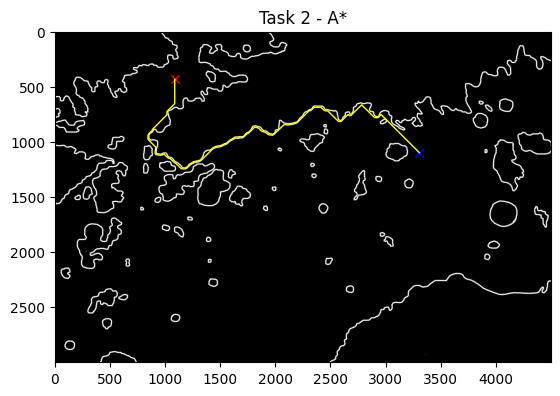

In [13]:
data = np.load('Data/path1minusSqrt.npy')
path = np.array(data)
print('The size of the retrieved path is:', path.size)
plt.figure("Task 2")
plt.title("Task 2 - A*")
plt.imshow(obstacleMap, cmap='gray')
plt.plot([A_star_start_ind[1]], [A_star_start_ind[0]], color='blue', marker='x', markersize=6)
plt.plot([A_star_goal_ind[1]], [A_star_goal_ind[0]], color='red', marker='x', markersize=6)
plt.plot(path[:, 1], path[:, 0], c='yellow', linestyle='-', linewidth=1)
plt.show()

## Conversion from indeces to coordinates

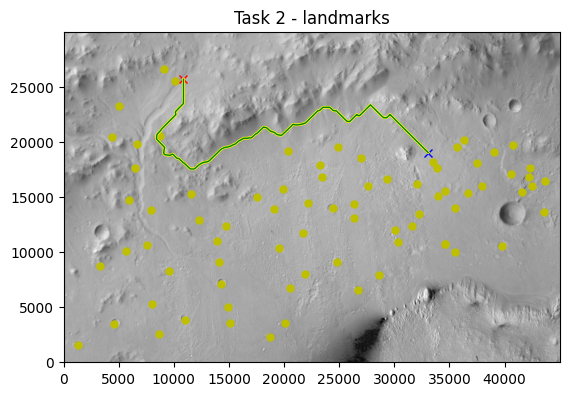

In [16]:
#convert the path from indices to coordinates
path_coords = [get_point(indices, X, Y, mapRes) for indices in path]
path_coords = np.array(path_coords)

# Array of indices
indices = np.arange(len(path_coords))

# 5th degree polynomial interpolations
spl_x = UnivariateSpline(indices, path_coords[:, 0], k=5, s=1)
spl_y = UnivariateSpline(indices, path_coords[:, 1], k=5, s=1)

# Set of indices for the interpolated path
indices_new = np.linspace(indices.min(), indices.max(), 10000000)

# The corresponding x and y values
x_interp = spl_x(indices_new)
y_interp = spl_y(indices_new)

# Collect x_interp and y_interp in a single array
path_interp = np.array([x_interp, y_interp]).T



plt.figure('Task 2 - landmarks')
plt.title('Task 2 - landmarks')
plt.imshow(env_map, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.plot(xLM, yLM, 'yo', markersize=5, linewidth=2)
plt.plot([A_star_start[0]], [A_star_start[1]], color='blue', marker='x', markersize=6)
plt.plot([A_star_goal[0]], [A_star_goal[1]], color='red', marker='x', markersize=6)
plt.plot(path_coords[:, 0], path_coords[:, 1], c='yellow', linestyle='-', linewidth=2)
# Plot the interpolated path
plt.plot(x_interp, y_interp, c='green', linestyle='-', linewidth=1)

plt.show()

In [17]:
# Calculate the differences between adjacent x and y values
dx = np.diff(path_interp[:, 0])
dy = np.diff(path_interp[:, 1])

# Calculate the angle at each point
angles = np.arctan2(dy, dx)

# Unwrap the angles to produce a smoothly varying angle
angles = np.unwrap(angles)

# Add the starting angle (converted to radians)
start_angle = np.deg2rad(180)
angles = np.concatenate(([start_angle], angles))

#collect the angles in a single array
path_angles_interp = np.array([x_interp, y_interp, angles]).T

print(path_angles_interp)
print(path_angles_interp.shape)


[[33070.000 19020.000     3.142]
 [33069.997 19020.003     2.356]
 [33069.994 19020.006     2.356]
 ...
 [10869.998 25669.994     1.571]
 [10869.998 25669.997     1.571]
 [10869.998 25670.000     1.571]]
(10000000, 3)


## Task 3: Rover Localization
Define Problem Parameters

In [4]:
# Retrieve Trajectory from Task 1
q_real = P_final.T            # N x 3 matrix containing the real pose state at each time step
tspan_real = tspan      # N x 1 array containing the timespan
# print(q_real)

# Define Model Parameters
sigma_x = 6                         # m
sigma_y = 6                         # m
sigma_theta_param = np.deg2rad(1)         # rad

# Define Initial Covariance Matrix
L0 = np.array([[sigma_x**2, 0, 0], [0, sigma_y**2, 0], [0, 0, sigma_theta_param**2]])

# Define Sensor Parameters
sigma_d = 0.004      # m         #odometer distance measurement noise
sigma_theta = np.deg2rad(0.05)      # rad       #odomter heading angle measurement noise

lidar_maxrange=500      #m         # lidar maximum range
sigma_r=0.010       # m         # lidar range measurement noise
sigma_beta=np.deg2rad(0.25)     #rad     # lidar bearing measurement noise


### Perform Dead Reckoning

In [6]:
q_est_dr, L_est_dr = dead_reckoning(q_real, sigma_d, sigma_theta, L0)

sqrt_det_L_dr = [np.sqrt(np.linalg.det(L_dr)) for L_dr in L_est_dr]

Processing: 100%|██████████| 33133/33133 [00:00<00:00, 72967.34it/s]


### Plot of the Path

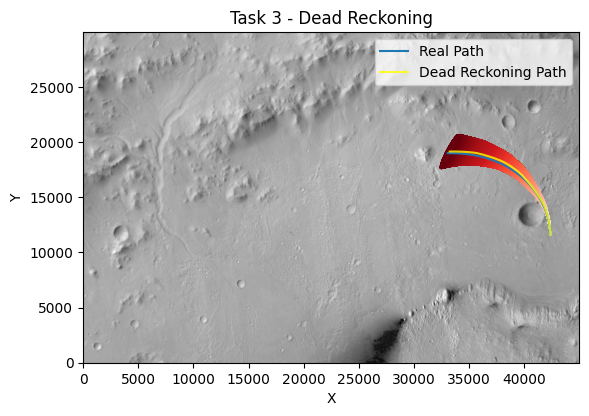

In [7]:
plt.figure("Task 3 - Dead Reckoning")
plt.title("Task 3 - Dead Reckoning")
plt.imshow(env_map, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.plot(q_real[:, 0], q_real[:, 1], label='Real Path')
plt.plot(q_est_dr[:, 0], q_est_dr[:, 1], label='Dead Reckoning Path', c='yellow', alpha= 0.8)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

compute_and_plot_ellipses(q_est_dr, L_est_dr, plt, frequency=1)

plt.show()

### Plot on the obstacle map
to show that avoids slope regions

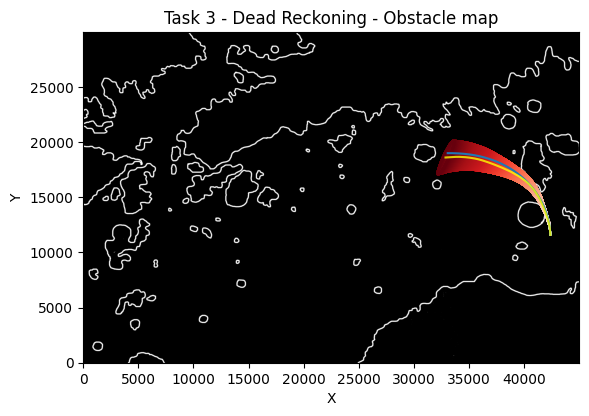

In [10]:
plt.figure("Task 3 - Dead Reckoning - Obstacle map")
plt.title("Task 3 - Dead Reckoning - Obstacle map")
plt.imshow(obstacleMap, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.plot(q_real[:, 0], q_real[:, 1], label='Real Path')
plt.plot(q_est_dr[:, 0], q_est_dr[:, 1], label='Dead Reckoning Path', c='yellow', alpha= 0.8)
plt.xlabel('X')
plt.ylabel('Y')

compute_and_plot_ellipses(q_est_dr, L_est_dr, plt, frequency=1)

plt.show()

### Visualize the Covariance Matrix Evolution

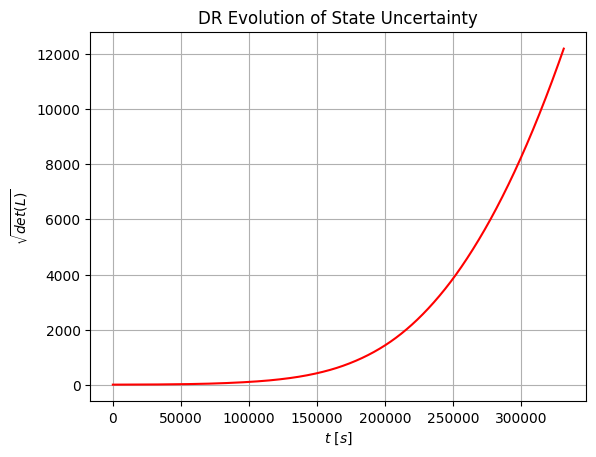

In [15]:
plt.figure("DR Covariance Matrix Evolution")
plt.plot(tspan, sqrt_det_L_dr, c='red')
plt.xlabel('$t \ [s]$')
plt.ylabel('$\sqrt{det(L)}$')
plt.title('DR Evolution of State Uncertainty')
plt.grid(True)
plt.show()

### Definition of observable functions

$z = h(q, lm) \qquad \qquad H_q = \frac{\partial h}{\partial q}$

### Perform the trajectory reconstruction with the EKF

In [9]:
noise_d_arr = []
noise_theta_arr = []
noise_r_arr= [] 
noise_beta_arr = []

q_est, L_est, noise_d_arr, noise_theta_arr, noise_r_arr, noise_beta_arr = EKF(q_real, sigma_d, sigma_theta, L0, lidar_maxrange, sigma_r, sigma_beta, noise_d_arr, noise_theta_arr, noise_r_arr, noise_beta_arr, xLM, yLM)

sqrt_det_L = [np.sqrt(np.linalg.det(L)) for L in L_est]


Processing:  69%|██████▊   | 22722/33133 [00:04<00:02, 4707.88it/s]

[499.984]


Processing: 100%|██████████| 33133/33133 [00:07<00:00, 4721.74it/s]


### Plot the estimated trajectory

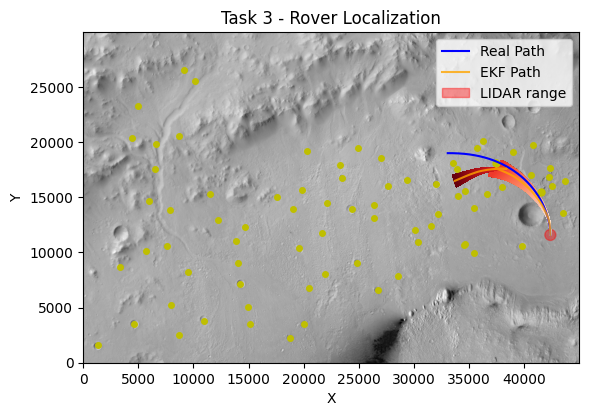

In [10]:
plt.figure("Task 3 - Rover Localization")
plt.title("Task 3 - Rover Localization")
plt.imshow(env_map, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.plot(xLM, yLM, 'yo', markersize=4, linewidth=1)
plt.plot(xLM[12], yLM[12], 'yo', markersize=5, linewidth=2)
plt.plot(xLM[0], yLM[0], 'yo', markersize=5, linewidth=2)
plt.plot(q_real[:, 0], q_real[:, 1], label='Real Path', c='Blue')
plt.plot(q_est[:, 0], q_est[:, 1], label='EKF Path', c='orange', linestyle='-', alpha= 0.8)
plt.xlabel('X')
plt.ylabel('Y')

#sow a circle of the radius of the lidar range
circle = Circle((q_est[0, 0], q_est[0, 1]), lidar_maxrange, label='LIDAR range', color='r', fill=True, alpha=0.4)
plt.gca().add_patch(circle)
plt.legend()

compute_and_plot_ellipses(q_est, L_est, plt, frequency=1)


plt.show()

### Visualize the Covariance Matrix Evolution

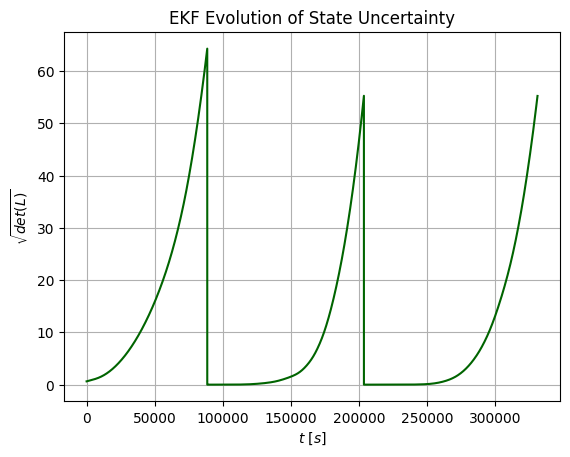

In [23]:
plt.figure("EKF Covariance Matrix Evolution")
plt.plot(tspan, sqrt_det_L, c='darkgreen')
plt.xlabel('$t \ [s]$')
plt.ylabel('$\sqrt{det(L)}$')
plt.title('EKF Evolution of State Uncertainty')
plt.grid(True)
plt.show()


## Optional

In [1]:
#perform dead reckoning on the path found by A*
q_Astar_est_dr, L_Astar_est_dr = dead_reckoning(path_angles_interp, sigma_d, sigma_theta, L0)

sqrt_det_L_Astar_dr = [np.sqrt(np.linalg.det(L_Astar_dr)) for L_Astar_dr in L_Astar_est_dr]

NameError: name 'dead_reckoning' is not defined

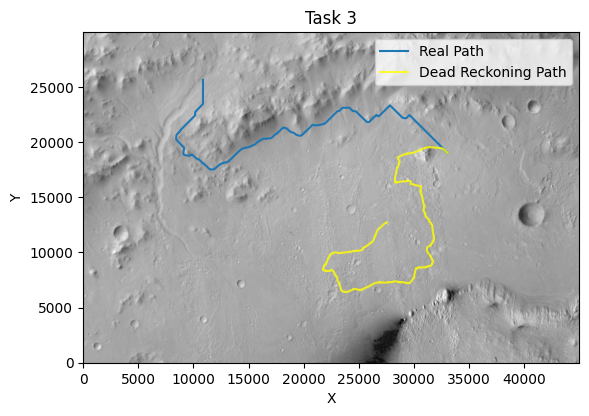

In [14]:
plt.figure("Task 3")
plt.title("Task 3")
plt.imshow(env_map, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.plot(path_angles_interp[:, 0], path_angles_interp[:, 1], label='Real Path')
plt.plot(q_Astar_est_dr[:, 0], q_Astar_est_dr[:, 1], label='Dead Reckoning Path', c='yellow', alpha= 0.8)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

# compute_and_plot_ellipses(q_Astar_est_dr, L_Astar_est_dr, plt, frequency=1)

plt.show()